In [11]:
#%% imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,ConcatDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
#%% importing dataset and dataloader
batch_size = 512
transform = transforms.Compose([transforms.ColorJitter(),transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root = '/',transform=transforms.ToTensor(),download=True)
augmented = datasets.CIFAR10(root = '/',transform=transform,download=True)
train_dataset = ConcatDataset([train_dataset,augmented])
train_loader = DataLoader(dataset = train_dataset,batch_size = batch_size,shuffle=True)
test_dataset = datasets.CIFAR10(root = '/',train = False,transform=transforms.ToTensor(),download=True)
test_loader = DataLoader(dataset = test_dataset,batch_size = int(len(test_dataset)/10),shuffle=True)
device = torch.device('cuda')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [21]:
#%% network
class Network(nn.Module):
    def __init__(self):   
        super().__init__()
        self.l1 = nn.Conv2d(3,32,3,padding = 1)
        self.n1 = nn.BatchNorm2d(32)
        self.l2 = nn.Conv2d(32,64,3,padding = 1)
        self.n2 = nn.BatchNorm2d(64)
        self.l3 = nn.Conv2d(64,64,3,padding = 1)
        self.n3 = nn.BatchNorm2d(64)
        self.l4 = nn.Conv2d(64,128,3,padding = 1)
        self.n4 = nn.BatchNorm2d(128)
        self.l5 = nn.Conv2d(128,128,3,padding = 1)
        self.n5 = nn.BatchNorm2d(128)
        self.l6 = nn.Conv2d(128,128,3,padding = 1)
        self.n6 = nn.BatchNorm2d(128)
        self.l7 = nn.Conv2d(128,128,3,padding = 1)
        self.n7 = nn.BatchNorm2d(128)
        self.l8 = nn.Conv2d(128,128,3,padding = 1)
        self.n8 = nn.BatchNorm2d(128)
        self.l9 = nn.Linear(512,128)
        self.l10 = nn.Linear(128,10)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p = 0.2)
        self.drop2d = nn.Dropout2d(p = 0.2)
        self.softmax = nn.Softmax()
        self.pool = nn.MaxPool2d(2,stride = 2)
    def forward(self,xt,flag = False):
      x = xt
      x = self.l1(x)
      x = self.n1(x)
      x = self.relu(x)
      x = self.pool(x)
      if(flag):
        x = self.drop2d(x)
      x = self.l2(x)
      x = self.n2(x)
      x = self.relu(x)
      x = self.l3(x)
      x = self.n3(x)
      x = self.relu(x)
      x = self.pool(x)
      if(flag):
        x = self.drop2d(x)
      x = self.l4(x)
      x = self.n4(x)
      x = self.relu(x)
      x = self.l5(x)
      x = self.n5(x)
      x = self.relu(x)
      x = self.l6(x)
      x = self.n6(x)
      x = self.relu(x)
      x = self.pool(x)
      if(flag):
        x = self.drop2d(x)
      x = self.l7(x)
      x = self.n7(x)
      x = self.relu(x)
      x = self.pool(x)
      if(flag):
        x = self.drop2d(x)
      x = self.l8(x)
      x = self.n8(x)
      x = self.relu(x)
      x = torch.reshape(x,(x.shape[0],-1,1,1))
      x = torch.squeeze(x,dim = 2)
      x = torch.squeeze(x,dim = 2)
      x = self.l9(x)
      x = self.relu(x)
      if(flag):
        x = self.drop(x)
      x = self.l10(x)
      x = self.softmax(x)
      return x

model = Network()
model.to(device)

Network(
  (l1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (n1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (n2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (n3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (n4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (n5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (n6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l7): Conv

In [54]:
#%% loss and optimiser
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)
lr_decay = torch.optim.lr_scheduler.StepLR(optimizer,2,gamma = 0.8)
def test(data):
    c = 0
    s = 0
    for x,y in (data):
        with torch.no_grad():
            x =x.to(device)
            y = y.to(device)
            yt = model(x)
            yt = torch.argmax(yt, dim= 1)
            c = (y == yt).sum()
            s = y.shape[0]
        break
    return (100*c/s).item()

In [19]:
model.load_state_dict(torch.load('/model_state1'))

<All keys matched successfully>

In [57]:
#%% epochs
epochs = 100
lr_decay = torch.optim.lr_scheduler.StepLR(optimizer,10,gamma = 0.5)
flag = False
from google.colab import files
for j in range(epochs):
    for i,(xt,yt) in enumerate(train_loader) :
        xt = xt.to(device)
        yt = yt.to(device)
        y_pred = model(xt,True)
        loss = cost(y_pred,yt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(i%20==0):
          acc = test(test_loader)
          print(f'epoch {j+1} step {i} loss {loss} test_accuracy {acc} train_accuracy {test(train_loader)}')
          if(acc>84):
            flag = True
            break
        else:
            print(f'epoch {j+1} step {i} loss {loss}')
    if(flag):
      break
    lr_decay.step()
    torch.save(model.state_dict(), '/model_state1')
    torch.save(optimizer.state_dict(), '/optim_state1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Streaming output truncated to the last 5000 lines.
epoch 8 step 81 loss 1.6346886157989502
epoch 8 step 82 loss 1.6426011323928833
epoch 8 step 83 loss 1.639945387840271
epoch 8 step 84 loss 1.6520259380340576
epoch 8 step 85 loss 1.6772704124450684
epoch 8 step 86 loss 1.6549545526504517
epoch 8 step 87 loss 1.6781038045883179
epoch 8 step 88 loss 1.655622959136963
epoch 8 step 89 loss 1.6322286128997803
epoch 8 step 90 loss 1.6545056104660034
epoch 8 step 91 loss 1.6367263793945312
epoch 8 step 92 loss 1.6509989500045776
epoch 8 step 93 loss 1.6577428579330444
epoch 8 step 94 loss 1.6584699153900146
epoch 8 step 95 loss 1.6876848936080933
epoch 8 step 96 loss 1.6580097675323486
epoch 8 step 97 loss 1.6626014709472656
epoch 8 step 98 loss 1.652592420578003
epoch 8 step 99 loss 1.6738935708999634
epoch 8 step 100 loss 1.6614277362823486 test_accuracy 78.4000015258789 train_accuracy 86.1328125
epoch 8 step 101 loss 1.6533496379852295
epoch 8 step 102 loss 1.6420512199401855
epoch 8 step

In [58]:
test_loader1 = DataLoader(dataset = test_dataset,batch_size = len(test_dataset),shuffle=True)
test(test_loader1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


81.22999572753906

In [ ]:
#%% saving state
from google.colab import files
torch.save(model, '/model 75')
torch.save(optimizer.state_dict(), '/optim_state 75')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 1 loss 2.303746223449707
epoch 2 loss 2.303746223449707
epoch 3 loss 2.303746223449707
epoch 4 loss 2.303746223449707
epoch 5 loss 2.303746223449707
epoch 6 loss 2.303746223449707
epoch 7 loss 2.303746223449707
epoch 8 loss 2.303746223449707
epoch 9 loss 2.303746223449707
epoch 10 loss 2.303746223449707
epoch 11 loss 2.303746223449707
epoch 12 loss 2.303746223449707
epoch 13 loss 2.303746223449707
epoch 14 loss 2.303746223449707
epoch 15 loss 2.303746223449707
epoch 16 loss 2.303746223449707
epoch 17 loss 2.303746223449707
epoch 18 loss 2.303746223449707
epoch 19 loss 2.303746223449707
epoch 20 loss 2.303746223449707
epoch 21 loss 2.303746223449707
epoch 22 loss 2.303746223449707
epoch 23 loss 2.303746223449707
epoch 24 loss 2.303746223449707
epoch 25 loss 2.303746223449707
epoch 26 loss 2.303746223449707
epoch 27 loss 2.303746223449707
epoch 28 loss 2.303746223449707
epoch 29 loss 2.303746223449707
epoch 30 loss 2.303746223449707
epoch 31 loss 2.303746223449707
epoch 32 loss 2.3

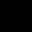

In [ ]:
#%% test
raw_image = torch.ones((2,3,32,32))
raw_image = raw_image*255
raw_image = raw_image.to(device)
raw_image.requires_grad = True
image_description = torch.Tensor([1,1])
image_description = image_description.to(torch.int64)
image_description = image_description.to(device)
optimizer_make = torch.optim.Adam([raw_image],lr = 0.001)
for i in model.parameters():
    i.requires_grad = False
runs = 1000
for i in range(runs):
    y_pred = model(raw_image)
    loss = cost(y_pred,image_description)
    optimizer_make.zero_grad()
    loss.backward()
    optimizer_make.step()
    print(f'epoch {i+1} loss {loss}')
raw_image = raw_image.squeeze()
t = transforms.ToPILImage()
image = t(raw_image[0])
display(image)